**PREDICCIONES SOBRE LOS PRECIOS DE INMUEBLES EN ITALIA, 2010-2023**

**1. Presentación de la empresa**

Casa.it es un sitio enfocado en quienes buscan una casa y para los profesionales inmobiliarios. Como el primer sitio italiano que puso en contacto a vendedores e inquilinos con quienes buscan una casa, Casa.it es hoy una de las principales plataformas digitales de bienes raíces en Italia.

Un corredor de propiedades del sitio nos contacto para realizar un estudio, para identificar las propiedades más convenientes a la hora de ofrecer a sus clientes, obtener una prediccion de los mejores lugares para ofrecer en el futuro, y estar más atento a las propiedades que se publican en ciertas ubicaciones.

**2. Contexto Empresarial**

La industria inmobiliaria en Italia es un sector importante de la economía del país. Cuenta con un mercado diversificado que abarca desde viviendas residenciales hasta propiedades comerciales y turísticas.

En las principales ciudades la demanda de propiedades es alta debido a su historia, cultura y atractivo turístico. Esto ha llevado a una continua inversión en bienes raíces.

Sin embargo, también ha enfrentado desafíos en los últimos años. La crisis económica global y la inestabilidad política interna han impactado en cierta medida la confianza de los clientes en Casa.it, además, la burocracia y la regulación a veces pueden ralentizar el proceso de compra o venta de propiedades.

Por eso, un Corredor de propiedades recopilo toda la informacion desde el año 2010 - 2023, para estudiar el comportamiento y predecir como se podria mover el precio en el mercado inmobiliario en el tiempo, abrir mas oportunidades para sus clientes, estar preparado de acuerdo a las necesidades de los mismos, y hacer el proceso mas dinamico.



**3. Problema Comercial**

Debemos revisar el dataset otorgado por el corredor de propiedades, limpiar y ajustar las variables del dataset de acuerdo a las necesidades para poder generar insights de interes, para visualizar como se comportan de acuerdo a los distintos puntos de vista.

**4. Contexto Analítico**

Se proporciona un dataset que contiene los datos de publicaciones para ventas de distintas propiedades en el sitio Casa.it, como la ubicacion de la propiedad, la superficie, cantidad de habitaciones, clasificación energetica, etc.

El corredor de propiedades no ha especificado lo que quiere saber, solo quiere que se realice el estudio orientado al precio de las propiedades. Por lo que se deberan generar distintas preguntas que podrian ser de interes, para el estudio.

**5. Fuente de datos y criterios de selección**

Los datos recopilados se exportaron de la plataforma Keaggle, los cuales fueron obtenidos de la plataforma Casa.it


**6. Objetivos y preguntas para el desarrollo de la investigación**

**Objetivos:**

Encontrar la relación que existe entre las variables por definir y el precio de la vivienda.

**Insights:**

**1.** Factores generales que influyen en el precio de un inmueble

   **1.2** La superficie de los inmuebles influye en el precio de los mismos.
    
   **1.3** Los tipos de inmuebles influyen en su precio.
    
   **1.4** La cantidad de baños por habitacion en los inmuebles influyen en su precio.
    
   **1.5** La Clasificación energetica influye en el precio del inmueble.
    
   **1.5.1** La superficie de la vivienda influye en su clasificación energetica.
   
   **1.6** La región donde se encuentra ubicada influye en el precio de la vivienda.
   
   **2** Tendencias de tipos de inmuebles según la región.
   
   **3** Hay relación entre la superficie del inmueble y sus distintas dependencias. 
   
   **4** La cantidad de dependencias, hay una mayor o menor eficiencia energética.

**7. Análisis Exploratorio de los Datos (EDA):**

**Historia de los datos**

Casa.it pone a disposición de quien busca una casa una amplia gama de casas en venta y alquiler, en toda Italia, de todo tipo, como apartamentos, áticos, villas, cabañas, lofts, propiedades de prestigio y las tecnologías más innovadoras disponibles que le permiten encontrar las casas que mejor se adaptan a sus necesidades de la manera más sencilla posible.

Se pueden encontrar entre muchos anuncios inmobiliarios para comprar una propiedad o alquilar una casa, una agencia inmobiliaria o publicar un anuncio.


**Exploramos los datos**

In [1]:
#Librerias necesarias
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.formula.api as sm1
import statsmodels.api as sm
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from funpymodeling.exploratory import freq_tbl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')

##Funciones para seleccion

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    pvals = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
            pvals.append(new_pval.min())
            print(best_features, new_pval.min())
        else:
            break
    return best_features, pvals

def backward_elimination(data, target, significance_level = 0.05):
    features = data.columns.tolist()
    worst_features = []
    pvals = []
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        print(features, p_values.min())
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            worst_features.append(excluded_feature)
            pvals.append(p_values.max())
        else:
            break
    return features, worst_features, pvals

def stepwise_selection(data, target, SL_in=0.05, SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            print(best_features, new_pval.min())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                    print(best_features, p_values.max())

                else:
                    break
        else:
            break
    return best_features,

In [5]:
#Importamos el dataset para el tratamiento y visualización de los datos.
data = pd.read_csv('https://raw.githubusercontent.com/LiuvaSalas/Coder_Liuva/main/italy_housing_price_rent_clean.csv', sep = ',')

#Tomamos una muestra para que sea optimo en tiempo al correr el codigo por la cantidad de datos.
df = data
df.head()

#Elimnamos unas filas con valores NaN en la columna Región
df = df[df['region'].notna()]
df = df[df['calificacion_energetica'].notna()]
df = df[df['estado'].notna()]

#Limpiamos los valores del dataset
df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
df['precio'] = df['precio'].astype(int)

# Calcular el precio promedio excluyendo los valores cero
precio_promedio = df.loc[df['precio'] != 0, 'precio'].mean()

# Reemplazar los valores cero por el precio promedio
df['precio'] = df['precio'].replace(0, precio_promedio)

#Convertimos variables de decimal a entero
df['precio'] = df['precio'].astype(int)
df['superficie'] = df['superficie'].astype(int)
df['villa'] = df['villa'].astype(int)
df['departamento'] = df['departamento'].astype(int)

In [3]:
#Convertimos la columna datetime a datetime para poder usar funciones relacionadas con la libreria.
df['datetime']= pd.to_datetime(df['datetime'])

#insertamos la columna anho al dataframe original para procedimientos posteriores
df.insert(loc = 5, column = "anho", value = df['datetime'].dt.year, allow_duplicates = False)


In [4]:
# Codificamos las variables categóricas a numéricas
a_numerica = ce.OrdinalEncoder(cols=['region', 'ciudad', 'cuarto', 'precio', 'datetime', 'anho',
       'plazas_de_aparcamiento', 'banos_por_habitacion', 'banos',
       'habitaciones', 'ultimo_piso', 'estado', 'calificacion_energetica',
       'Vista_al_mar', 'calentamiento_centralizado', 'superficie', 'amueblado',
       'balcon', 'sistema_de_television', 'exposicion_externa', 'fibra_optica',
       'porton_electrico', 'cava', 'jardin_comun', 'jardin_privado',
       'sistema_de_alarmas', 'portero', 'piscina', 'villa', 'propiedad_entera',
       'departamento', 'atico1', 'loft', 'atico2'])

# Definimos un dataframe para el cálculo del PCA 
df1 = a_numerica.fit_transform(df)


**Filtros aplicados a los datos.**

Se han importado las bibliotecas necesarias para el desarrollo del análisis exploratorio. Se ha cargado el Dataset a un Dataframe general llamado “df”, con la posibilidad de usarlos independientemente. Se ha chequeado la forma del Dataframe, su información, el tipo de datos que contiene y la cantidad de columnas. Se ha transformado la variable 'Fecha' de tipo objeto a tipo dato de tiempo, transformado algunas variables de decimal a entero para su mejor visualización, eliminado NaN, y reemplazado por ceros o por la media de la variable.


**Objetivo**:
Seleccionamos las variables que vamos a estudiar


**Exploración de los datos**:

**region**: Región de Italia donde se encuentran ubicadas las propiedades

**precio**: Precios de las propiedades en Euros

**datetime**: Fecha de publicación de las propiedades

**banos_por_habitacion**: Numero de baños por habitación

**habitaciones**: Número de habitaciones dentro de la propiedad

**estado**: El estado de la propiedad, si esta nuevo, o reacondicionado.

**calificacion_energetica**: La Clasificación energética de la propiedad de acuerdo al consumo.

**superficie**: La Superficie de la propiedad.

**villa**: Si la propiedad es una casa.

**departamento**: Si la propiedad es un departamento.


**8. Análisis de los Componentes Principales (PCA):**

In [5]:
# Entrenamos el modelo PCA con escalado de los datos agrupamos en un pipeline
pipe_pca = make_pipeline(MinMaxScaler(), PCA())
pipe_pca.fit(df1)
modelo_pca = pipe_pca.named_steps['pca']

Text(0, 0.5, '% Varianza Acumulada')

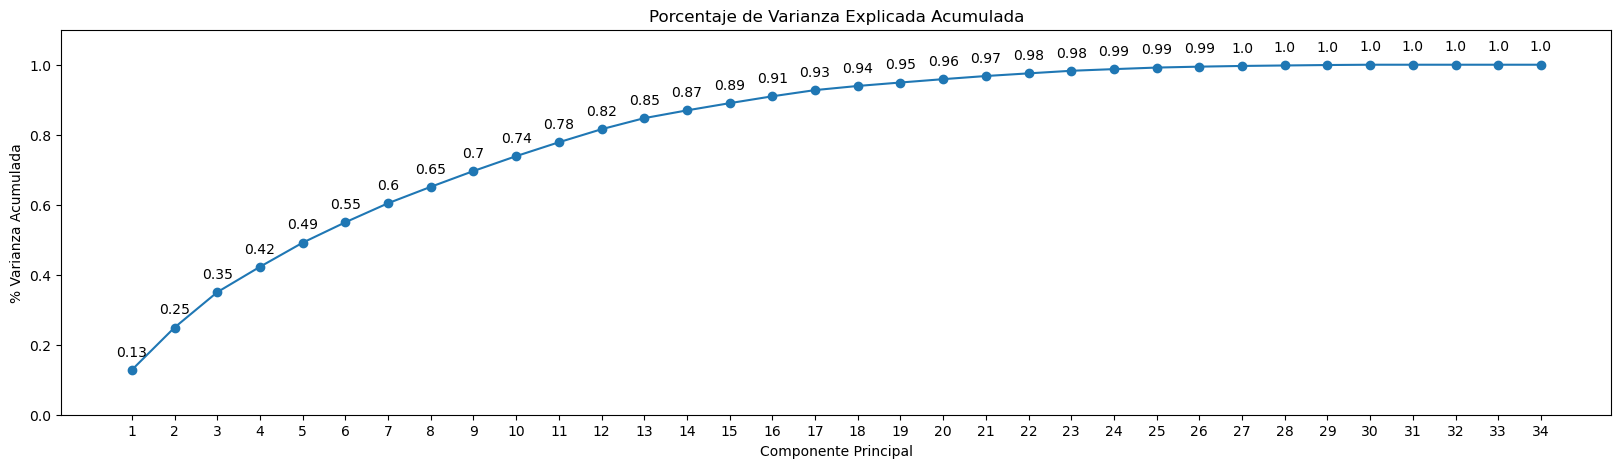

In [6]:
# Calculamos el porcentaje de varianza explicada acumulada
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()


# Lo mostramos en un gráfico
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
ax.plot(np.arange(len(df1.columns)) + 1, prop_varianza_acum, marker = 'o')
for x, y in zip(np.arange(len(df1.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de Varianza Explicada Acumulada')
ax.set_xlabel('Componente Principal')
ax.set_ylabel('% Varianza Acumulada')


Se puede notar que entre las muestras 17 y 18 ya podemos explicar el 95% de los datos.

In [7]:
# Definimos ahora un nuevo dataframe para mostrar el trabajo del PCA en columnas
pca_df = df1
pca_df2 = pca_df
pca_df = MinMaxScaler().fit_transform(pca_df)
pca_df = pd.DataFrame(pca_df,columns=pca_df2.columns).set_index(pca_df2.index)


In [8]:
# Procedemos a aplicar el PCA y calcular los porcentajes en las muestras explicadas anteriormente
pca = PCA(n_components=18)
principalComponents = pca.fit_transform(pca_df)
principalComp_Df = pd.DataFrame(data = principalComponents, columns = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11','pca12','pca13'
                                                                      ,'pca14','pca15','pca16','pca17','pca18']).set_index(pca_df.index)
print("Forma del dataframe de los Componentes Principales", principalComp_Df.shape)
explicacion = pca.explained_variance_ratio_
print(explicacion)

Forma del dataframe de los Componentes Principales (50339, 18)
[0.12808089 0.12110816 0.10094045 0.07251772 0.06886299 0.05833373
 0.05441431 0.04684547 0.04517165 0.04256397 0.03959547 0.03727768
 0.03165516 0.02220072 0.02060063 0.01961979 0.01771609 0.01180913]


Como se pudo observar con el propósito de reducir la dimensionalidad del Dataframe a un 90/95 porciento de explicación con el mínimo de columnas posibles es suficiente y se podría concluir que acotando nuestro Dataframe principal a 17 columnas tendríamos suficientes componentes principales para llevar el estudio de nuestros datos con éxito.

In [9]:
#Eliminamos las variables que no se utilizarán
df = df.drop(columns=['sistema_de_television', 'sistema_de_alarmas', 'portero', 'propiedad_entera'])


**9. Gráfica de Datos:**

**9.1 Análisis Univariado**

In [10]:
# Calcular los percentiles
q1 = df["precio"].quantile(0.25)
q3 = df["precio"].quantile(0.75)

# Calcular el rango intercuartil
iqr = q3 - q1

# Definir límites para identificar valores atípicos
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Excluir los valores que no son atípicos
df = df[(df["precio"] >= lower_bound) & (df["precio"] <= upper_bound)]

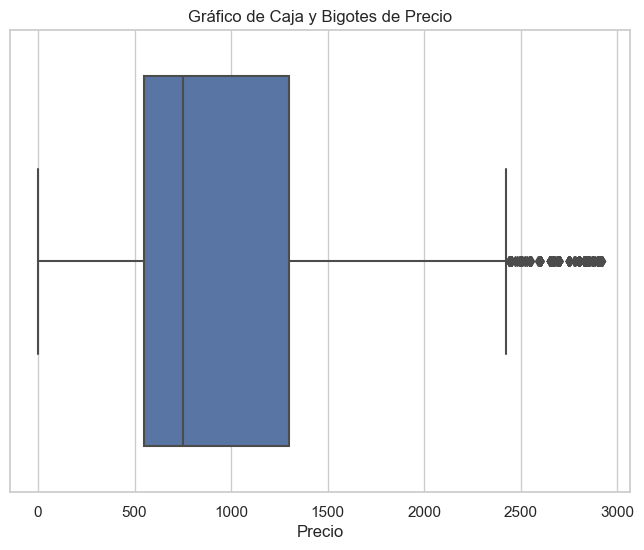

In [11]:
#Configuración del grafico
sns.set(style="whitegrid")

#Grafico de Caja y Bigotes para visualizar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["precio"], palette = "deep")
plt.title("Gráfico de Caja y Bigotes de Precio")
plt.xlabel("Precio")
plt.show()

Lo que se puede reflejar en la visualización es que los datos no se encuentran concentrados en su totalidad, y que hay muchos datos atípicos.

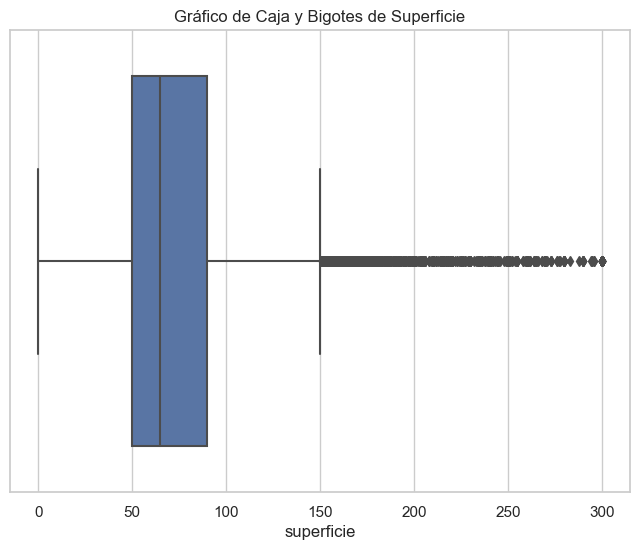

In [12]:
#Configuración del grafico
sns.set(style="whitegrid")

#Grafico de Caja y Bigotes para visualizar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["superficie"])
plt.title("Gráfico de Caja y Bigotes de Superficie")
plt.xlabel("superficie")
plt.show()

Al igual que en la variable "precio", se pueden encontrar muchos valores atípicos.

**Análisis de la variable "Estado"**

In [13]:
#Visualizamos las frecuencias y porcentajes de las variables categoricas.
freq_tbl(df)

                 region  frequency  percentage  cumulative_perc
0                 lazio       7578    0.161968         0.161968
1             lombardia       7430    0.158805         0.320773
2              piemonte       5404    0.115502         0.436275
3        emilia-romagna       4907    0.104880         0.541155
4                veneto       3552    0.075919         0.617073
5               liguria       3456    0.073867         0.690940
6              campania       3316    0.070874         0.761814
7               sicilia       3032    0.064804         0.826619
8               toscana       2281    0.048753         0.875371
9                puglia       1255    0.026824         0.902195
10               marche       1217    0.026011         0.928207
11               umbria       1018    0.021758         0.949965
12              abruzzo        792    0.016928         0.966893
13  trentino-alto-adige        440    0.009404         0.976297
14             sardegna        416    0.

In [14]:
# Creamos un dataframe con las frecuencias y porcentajes de la variable "Estado"
estado_freq = freq_tbl(df['estado'])
estado_freq

,estado,frequency,percentage,cumulative_perc
0,ottimo / ristrutturato,27979,0.598008,0.598008
1,buono / abitabile,16747,0.357941,0.955949
2,nuovo / in costruzione,1751,0.037425,0.993374
3,da ristrutturare,310,0.006626,1.000000


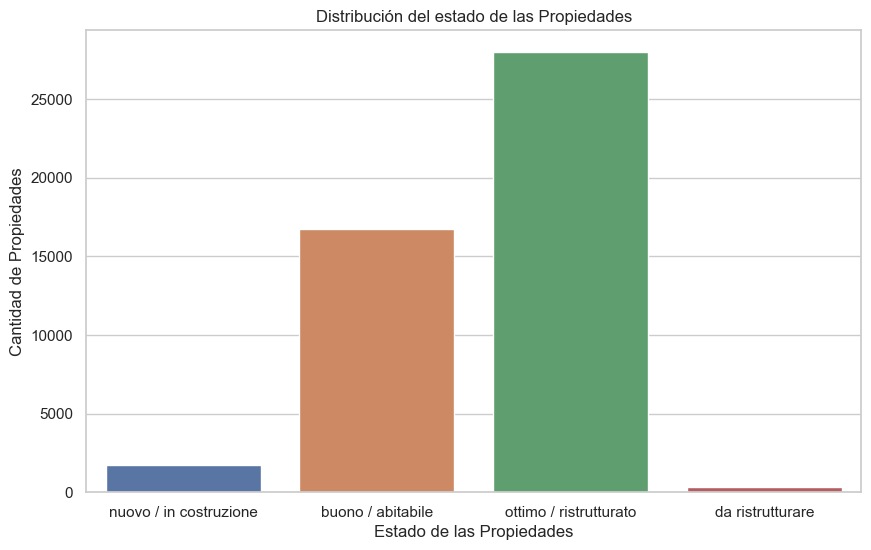

In [15]:
# Gráfico de barras con datos sobre el estado de las propiedades
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='estado', palette='deep')

# Personalización del grafico
plt.title('Distribución del estado de las Propiedades')
plt.xlabel('Estado de las Propiedades')
plt.ylabel('Cantidad de Propiedades')


#View del gráfico
plt.show()

La mayoría de las publicaciones inmobiliarias están en un estado óptimo a restaurado, seguido por bueno o en buen estado.

**Análisis de la variable "Región"**

In [16]:
# Creamos un dataframe con las frecuencias y porcentajes de la variable "Región"
region_freq = freq_tbl(df['region'])
region_freq['percentage%'] = round(region_freq['percentage']*100, 1)


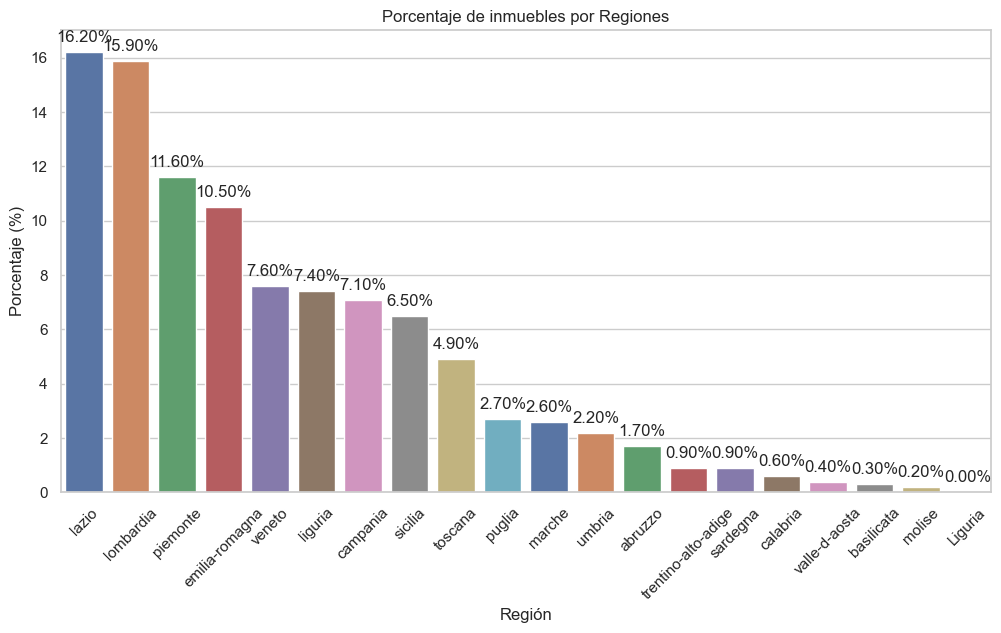

In [17]:
# Gráfico de barras con datos sobre el Porcentaje de propiedades por Región
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='region', y='percentage%', data=region_freq, palette = "deep")
plt.title("Porcentaje de inmuebles por Regiones")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Región")
plt.xticks(rotation=45)
# Agregar etiquetas a las barras
for index, row in region_freq.iterrows():
    plt.annotate(f"{row['percentage%']:.2f}%", 
                 xy=(index, row['percentage%']), 
                 xytext=(0, 5),  # Ajustar la posición vertical del texto
                 textcoords='offset points',
                 ha='center', va='bottom')


plt.show()

Las regiones Lombardía y Lazio representan el 32% de las publicaciones de inmuebles en venta.

**Análisis de la variable "Clasificación Energética"**

In [18]:
# Creamos un dataframe con las frecuencias y porcentajes de la variable "Calificación Energetica"
calf_freq = freq_tbl(df['calificacion_energetica'])
calf_freq

,calificacion_energetica,frequency,percentage,cumulative_perc
0,G,21098,0.450937,0.450937
1,F,5697,0.121765,0.572702
2,E,4594,0.098190,0.670891
3,D,4508,0.096352,0.767243
4,A,4375,0.093509,0.860752
5,C,3968,0.084810,0.945562
6,B,2547,0.054438,1.000000


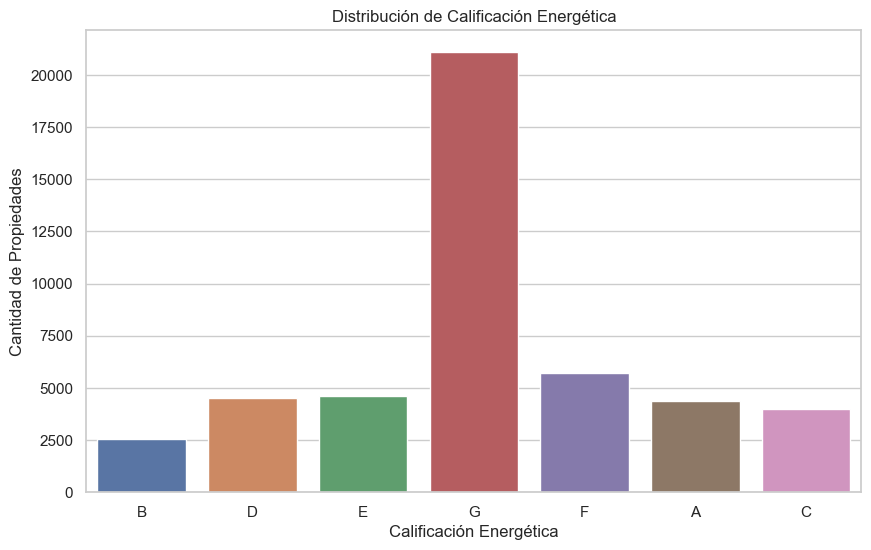

In [19]:
#Especificaciones del gráfico
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='calificacion_energetica', palette='deep')

# Personaliza el gráfico
plt.title('Distribución de Calificación Energética')
plt.xlabel('Calificación Energética')
plt.ylabel('Cantidad de Propiedades')


# Muestra el gráfico
plt.show()

La mayoría de los inmuebles están en las peores clasificaciones energéticas "G" y "F", siendo la menor cantidad de inmuebles en las clasificaciones energéticas más convenientes.

**9.2 Análisis Bivariado:**

##### Tipos de inmuebles según la región

In [20]:
# Mapear los valores de las columnas a los nombres de tipo de inmueble
def map_tipo(row):
    if row['departamento'] == 1:
        return 'departamento'
    elif row['villa'] == 1:
        return 'villa'
    else:
        return None

# Crear la nueva columna "tipo de inmueble"
df['tipo_inmueble'] = df.apply(map_tipo, axis=1)

#Cruzamos las variables Region y tipo de inmueble
crostab = pd.crosstab(index=df['region'], columns=df['tipo_inmueble'])

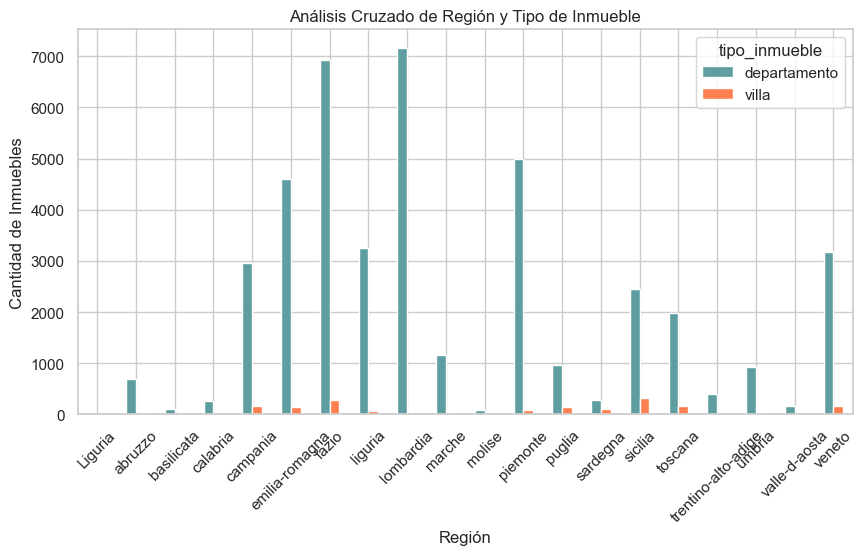

In [21]:
#Con el gráfico de barras, mostramos los resultados del análisis cruzado
colores_personalizados = ['cadetblue', 'coral']
ax = crostab.plot(kind='bar', figsize=(10, 5), color = colores_personalizados)

plt.title('Análisis Cruzado de Región y Tipo de Inmueble')
plt.xlabel('Región')
plt.ylabel('Cantidad de Inmuebles')
plt.xticks(rotation=45)

plt.show()

La mayoría de las villas publicadas se encuentran en Lazio, Sicilia y toscana, mientras que en términos generales las publicaciones son departamentos.

**Relación entre distintas dependencias y la superficie**

In [22]:
#Creamos un df2 con variables seleccionadas para realizar el analisis de correlación posteriormente.
df2 = df[['plazas_de_aparcamiento', 'banos',
       'habitaciones','calentamiento_centralizado', 'superficie', 'piscina', 'atico1']]


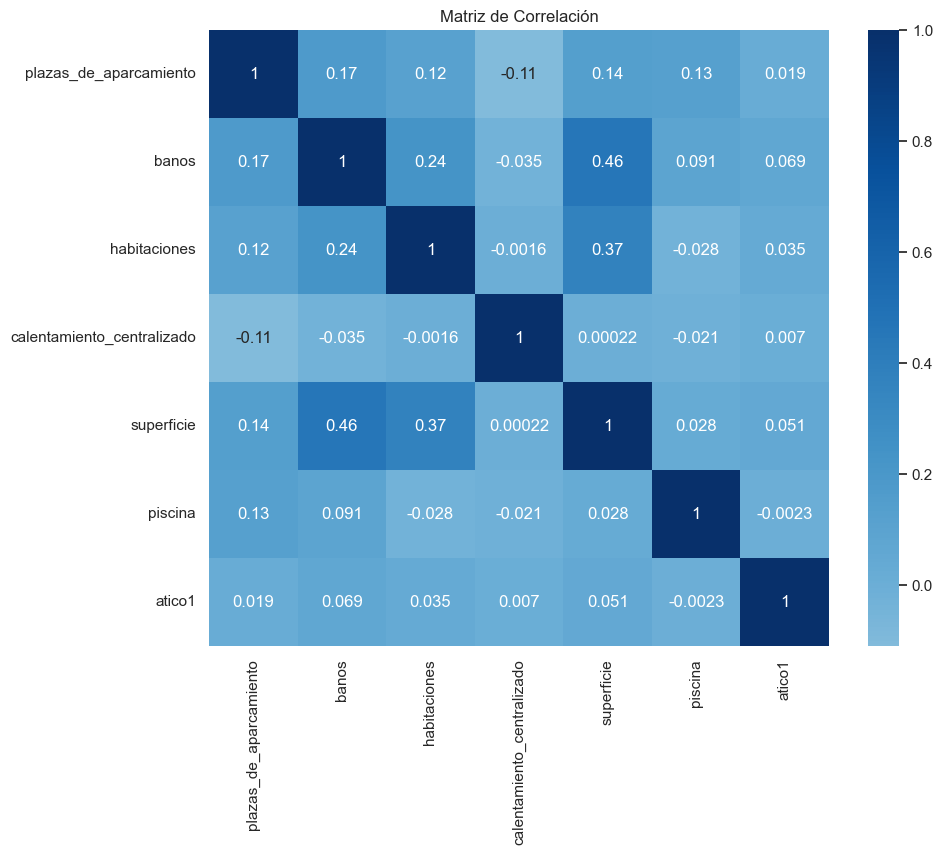

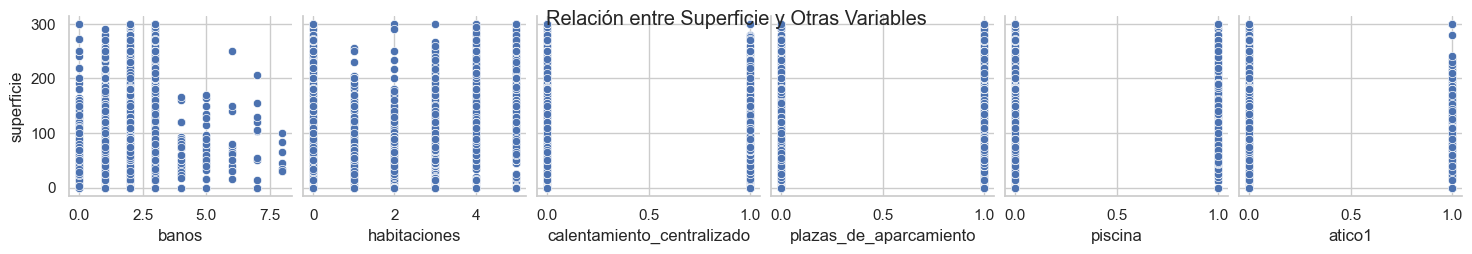

In [23]:
#Creamos una matriz de correlación con las variables seleccionadas anteriormente.
correlation_matrix = df2.corr()

# Crear un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Matriz de Correlación')
plt.show()

# Crear gráficos de dispersión para ver la relación entre "superficie" y otras variables
sns.pairplot(df2, x_vars=['banos', 'habitaciones', 'calentamiento_centralizado', 'plazas_de_aparcamiento', 'piscina', 'atico1'], y_vars=['superficie'], kind='scatter')
plt.suptitle('Relación entre Superficie y Otras Variables')
plt.show()

Las variables con más relación respecto a la superficie, son el número de habitaciones y el número de baños.

**Relación entre distintas dependencias y el precio de los inmuebles**

In [24]:
#Creamos un df3 con variables seleccionadas para realizar el analisis de correlación posteriormente.
df3 = df[['plazas_de_aparcamiento', 'banos',
       'habitaciones','calentamiento_centralizado', 'precio', 'piscina', 'atico1']]

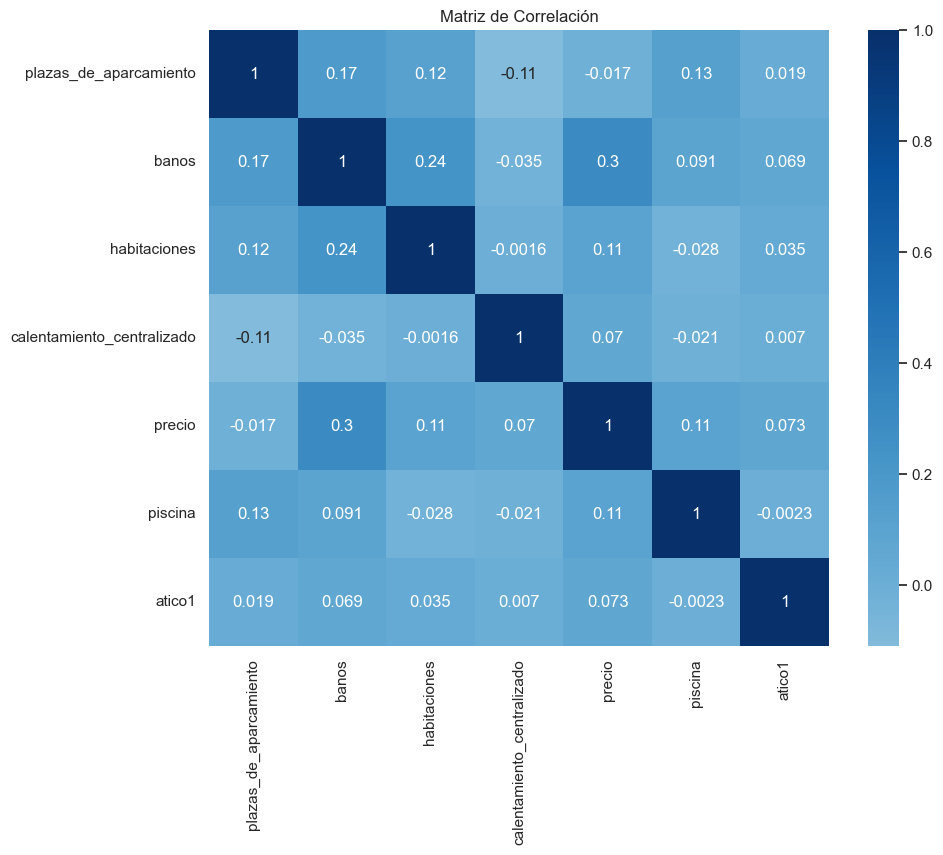

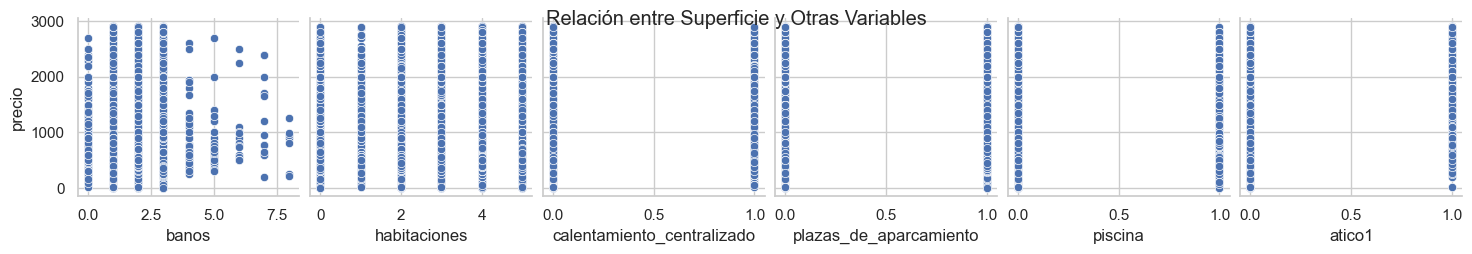

In [25]:
#Creamos una matriz de correlación con las variables seleccionadas anteriormente.
correlation_matrix = df3.corr()

# Crear un heatmap para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', center=0)
plt.title('Matriz de Correlación')
plt.show()

# Crear gráficos de dispersión para ver la relación entre "superficie" y otras variables
sns.pairplot(df3, x_vars=['banos', 'habitaciones', 'calentamiento_centralizado', 'plazas_de_aparcamiento', 'piscina', 'atico1'], y_vars=['precio'], kind='scatter')
plt.suptitle('Relación entre Superficie y Otras Variables')
plt.show()

La variable con más relación al precio es el número de baños.

**9.3 Analísis Multivariado**

La Calificación Energética depende de la cantidad de dependencias que tiene el inmueble:

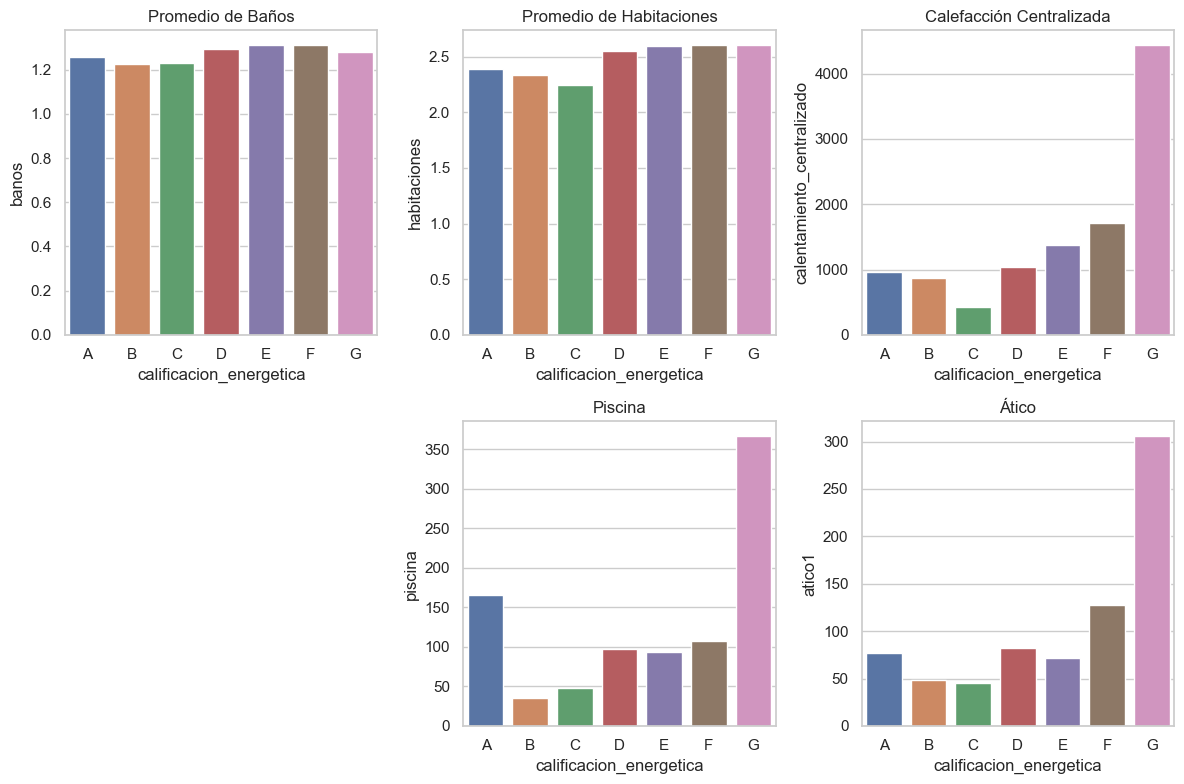

In [26]:
# Agrupar y calcular estadísticas
calificacion_group = df.groupby('calificacion_energetica').agg({
    'banos': 'mean',
    'habitaciones': 'mean',
    'plazas_de_aparcamiento': 'sum',
    'calentamiento_centralizado': 'sum',
    'piscina': 'sum',
    'atico1': 'sum'
}).reset_index()

# Crear gráficos de barras
plt.figure(figsize=(12, 8))

# Baños promedio por calificación energética
plt.subplot(2, 3, 1)
sns.barplot(data=calificacion_group, x='calificacion_energetica', y='banos', palette = "deep")
plt.title('Promedio de Baños')

# Habitaciones promedio por calificación energética
plt.subplot(2, 3, 2)
sns.barplot(data=calificacion_group, x='calificacion_energetica', y='habitaciones', palette = "deep")
plt.title('Promedio de Habitaciones')

# Calefacción centralizada por calificación energética
plt.subplot(2, 3, 3)
sns.barplot(data=calificacion_group, x='calificacion_energetica', y='calentamiento_centralizado', palette = "deep")
plt.title('Calefacción Centralizada')

# Piscina por calificación energética
plt.subplot(2, 3, 5)
sns.barplot(data=calificacion_group, x='calificacion_energetica', y='piscina', palette = "deep")
plt.title('Piscina')

# Ático por calificación energética
plt.subplot(2, 3, 6)
sns.barplot(data=calificacion_group, x='calificacion_energetica', y='atico1', palette = "deep")
plt.title('Ático')

plt.tight_layout()
plt.show()

Los inmuebles donde tienen Piscina, Ático y Calefacción Centralizada tienen una Calificación Energética más deficiente.
Mientras que en los inmuebles con dependencias de baños y habitaciones, está distribuido de manera equitativa entre las distintas Calificaciones Energéticas.


##### Relación entre la variable superficie y precio

In [27]:
#Creamos un dataframe para agrupar los precios promedio superficie
precio_prom_sup = df.groupby('superficie')['precio'].mean().reset_index()
precio_prom_sup['superficie'] = np.where(precio_prom_sup['superficie'] < 50, np.nan, precio_prom_sup['superficie'])
precio_prom_sup = precio_prom_sup.dropna().reset_index(drop=True)

**¿La superficie de los inmuebles influye en su precio?**

In [28]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
x = precio_prom_sup['precio'].values
y = precio_prom_sup['superficie'].values
print(x.shape, y.shape)

(221,) (221,)


In [30]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [31]:
regr = linear_model.LinearRegression()
regr.fit(x, y)
y_pred = regr.predict(x)
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

Coefficients: 
 [[0.11595877]]
Mean squared error: 2101.84
Coefficient of determination: 0.54


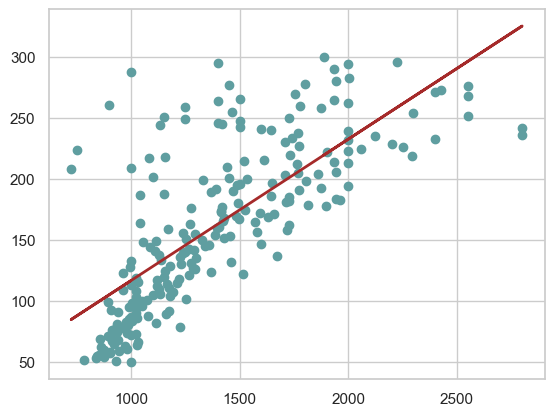

In [32]:
plt.scatter(x, y, color="cadetblue")
plt.plot(x, y_pred, color="brown", linewidth=2)

plt.show()

El precio tiene relación directa con la superficie, los puntos se encuentran bastante cerca del promedio general.

Text(0.5, 1.0, 'Precio Promedio por Superficie')

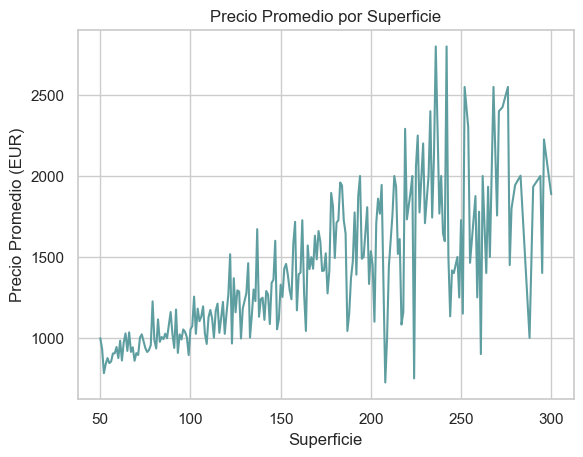

In [33]:
#Grafico de lineas con Matplotlib
fig, ax = plt.subplots()
ax.plot(precio_prom_sup['superficie'], precio_prom_sup['precio'], color = "cadetblue")

#Agregamos las etiquetas para una mejor lectura del grafico
plt.xlabel('Superficie')
plt.ylabel('Precio Promedio (EUR)')
plt.title('Precio Promedio por Superficie')

En promedio, los precios más altos se encuentran entre una superficie 200mts2 - 300mtrs2

**¿El tipo de inmueble influye en el precio del mismo?**

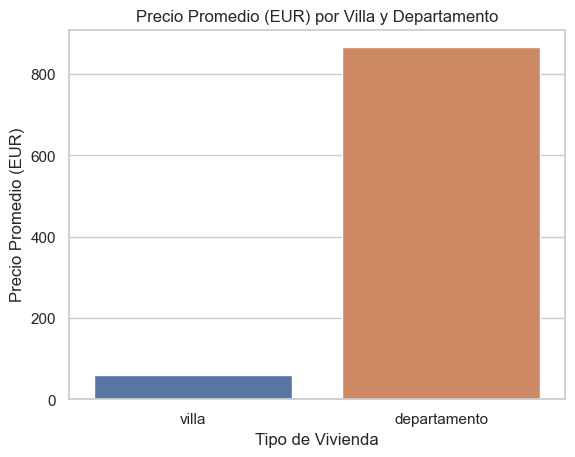

In [34]:
#Separamos las variables que queremos graficar en un dataframe
vivienda = df[['precio', 'villa', 'departamento']]

#Reemplazamos los valores que nos interesan para hacer el comparativo
vivienda.loc[vivienda['villa'] == 1.0, 'villa'] = vivienda.loc[vivienda['villa'] == 1.0, 'precio']
vivienda.loc[vivienda['departamento'] == 1.0, 'departamento'] = vivienda.loc[vivienda['departamento'] == 1.0, 'precio']
vivienda = vivienda[['villa', 'departamento']]

# Definimos una funcion para generar los decimales, porque por algun motivo no me deja de otra manera
def round_decimals(value, decimals):
    return round(value, decimals)

#Generamos las variables para asignar los promedios
prom_villa = vivienda['villa'].mean()
prom_villa = round_decimals(prom_villa, 2)
prom_departamento = vivienda['departamento'].mean()
prom_departamento = round_decimals(prom_departamento, 2)

# Creamos un DF con los promedios de cada vivienda para generar el grafico comparativo
vivienda = pd.DataFrame({'villa': [prom_villa], 'departamento': [prom_departamento]})
vivienda

# Crear el gráfico de barras utilizando Seaborn
sns.barplot(data=vivienda, palette = "deep")

# Configuramos las etiquetas
plt.xlabel('Tipo de Vivienda')
plt.ylabel('Precio Promedio (EUR)')
plt.title('Precio Promedio (EUR) por Villa y Departamento')

plt.show()

Los valores promedio de los departamentos son mucho más elevados que los valores de las villas/casas.

Text(0.5, 1.0, 'Comparación de Superficie Promedio entre Villas y Departamentos')

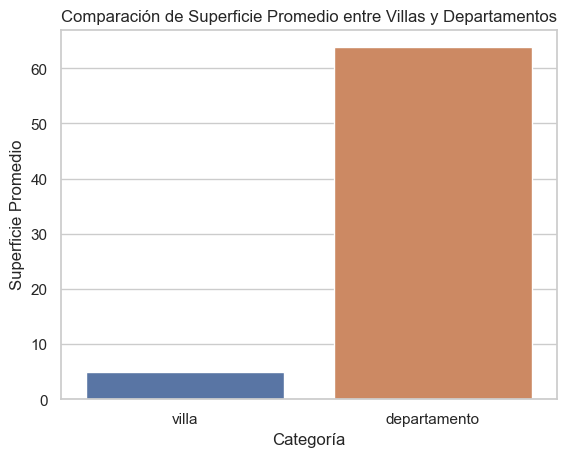

In [35]:
#Separamos las variables que queremos graficar en un dataframe
viviendasup = df[['superficie', 'villa', 'departamento']]

#Reemplazamos los valores que nos interesan para hacer el comparativo
viviendasup.loc[viviendasup['villa'] == 1.0, 'villa'] = viviendasup.loc[viviendasup['villa'] == 1.0, 'superficie']
viviendasup.loc[viviendasup['departamento'] == 1.0, 'departamento'] = viviendasup.loc[viviendasup['departamento'] == 1.0, 'superficie']
viviendasup = viviendasup[['villa', 'departamento']]

#Generamos las variables para asignar los promedios
prom_villasup = viviendasup['villa'].mean()
prom_villasup = round_decimals(prom_villasup, 2)
prom_departamentosup = viviendasup['departamento'].mean()
prom_departamentosup = round_decimals(prom_departamentosup, 2)

# Creamos un DF con los promedios de cada vivienda para generar el grafico comparativo
viviendasup = pd.DataFrame({'villa': [prom_villasup], 'departamento': [prom_departamentosup]})
viviendasup

df_superficie_promedio = pd.DataFrame({'Categoría': ['villa', 'departamento'],
                                       'Superficie Promedio': [prom_villasup, prom_departamentosup]})

# Crear el gráfico de líneas
sns.barplot(data=df_superficie_promedio, x='Categoría', y='Superficie Promedio', palette = "deep")

# Configurar las etiquetas y el título
plt.xlabel('Categoría')
plt.ylabel('Superficie Promedio')
plt.title('Comparación de Superficie Promedio entre Villas y Departamentos')


La superficie promedio de las villas/casas son menores que las superficies de los departamentos, pero esto puede deberse a que en nuestro Dataset hayan menos villas que departamentos, sin embargo aunque los samples sean pocos, los pocos que hay tienen una superficie menor.

**¿El número de baños influye el precio de la vivienda?**

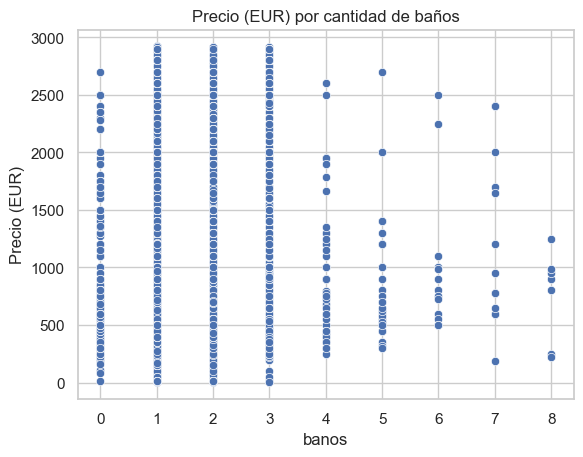

In [36]:
#Separamos las variables que queremos graficar en un dataframe
banporhab = df[['precio', 'banos']]
banporhab['banos'] = round_decimals(banporhab['banos'], 1)
banporhab

sns.scatterplot(data=banporhab, x='banos', y='precio', )
# Ajustar la escala del eje y
plt.ticklabel_format(style='plain', axis='y')

#Agregamos las etiquetas para una mejor lectura del grafico
plt.xlabel('banos')
plt.ylabel('Precio (EUR)')
plt.title('Precio (EUR) por cantidad de baños')

plt.show()

Si el inmueble tiene más baños no necesariamente tiene que ser más costoso.

**¿La Clasificación Energetica influye en el precio de la vivienda?**

In [37]:
#Creamos un dataframe para agrupar los precios promedio por Consumo energetico
precio_prom_consumo = df.groupby('calificacion_energetica')['precio'].mean().reset_index()
precio_prom_consumo['precio'] = round_decimals(precio_prom_consumo['precio'], 0)
precio_prom_consumo['precio'] = precio_prom_consumo['precio'].astype(int)

precio_prom_consumo.head()

,calificacion_energetica,precio
0,A,927
1,B,905
2,C,1289
3,D,945
4,E,972


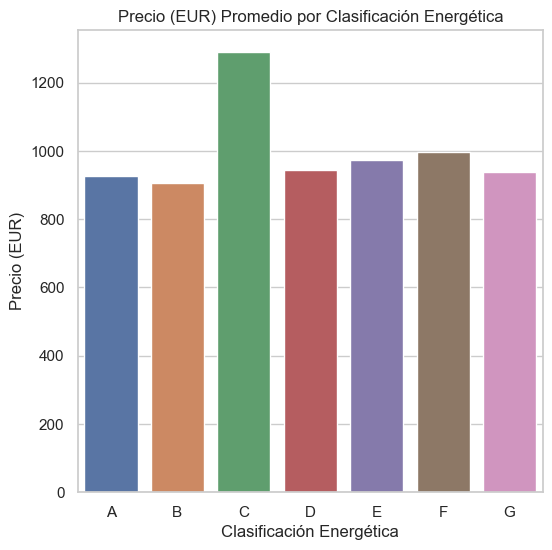

In [38]:
#Ajustamos el tamaño del grafico
plt.figure(figsize=(6, 6))

sns.barplot(data=precio_prom_consumo, x='calificacion_energetica', y='precio', palette = 'deep')

plt.title('Precio (EUR) Promedio por Clasificación Energética')
plt.xlabel('Clasificación Energética')
plt.ylabel('Precio (EUR)')



#Mostramos el gráfico
plt.show()



Varía el precio por Clasificación Energética de la propiedad, siendo que la mejor Clasificación Energética es entre A y C, el mayor precio se concentra en la Clasificación F, una de las peores.

**¿La superficie de la vivienda influye en la Clasificación Energetica?**

In [39]:
#Creamos un dataframe para agrupar las superficies promedio por consumo energetico
superf_prom_consumo = df.groupby('calificacion_energetica')['superficie'].mean().reset_index()

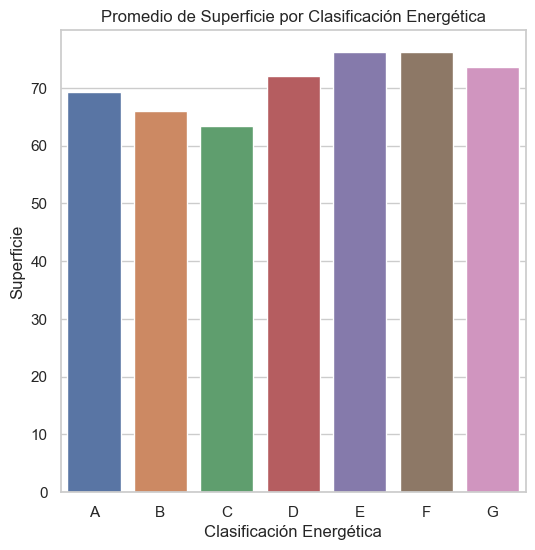

In [40]:
#Ajustamos el tamaño del gráfico
plt.figure(figsize=(6, 6))

sns.barplot(data=superf_prom_consumo, x='calificacion_energetica', y='superficie', palette = 'deep')

#Definimos las etiquetas y títulos para una mejor lectura de las variables del gráfico.
plt.title('Promedio de Superficie por Clasificación Energética')
plt.xlabel('Clasificación Energética')
plt.ylabel('Superficie')


plt.show()

La mayor clasificación energética se encuentra con la mayor superficie promedio por propiedad, lo que tiene sentido, ya que mientras más grande es la propiedad, mayor consumo energético tendrá, y por consecuencia mayor Clasificación Energética. Conclusión: Comprar una casa más pequeña garantiza menor consumo energético y también menor precio si contrastamos con el grafico anterior.

**¿La Región donde se encuentra ubicada la vivienda, influye en el precio de la misma?**

In [41]:
#Creamos un dataframe para agrupar las Regiones por Precio Promedio
precio_prom_region = df.groupby('region')['precio'].mean().sort_values(ascending=True).reset_index()
precio_prom_region['precio'] = round_decimals(precio_prom_region['precio'], 1)

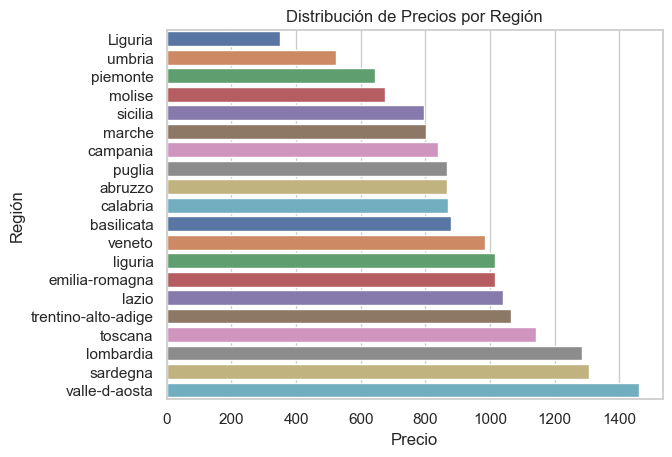

In [42]:

sns.barplot(data=precio_prom_region, y='region', x='precio', orient='h', palette="deep")

# Configurar las etiquetas y el título
plt.xlabel('Precio')
plt.ylabel('Región')
plt.title('Distribución de Precios por Región')

# Mostrar el gráfico de barras horizontal
plt.show()

El top #3 de las regiones con precios más bajos son Liguria, Umbría y Piamonte, y las regiones con valores más altos se concentran en Lombardía, Sardegnay Valle d Aosta, veamos en el siguiente grafico el comportamiento de acuerdo a la superficie de las propiedades.

In [43]:
#Creamos un dataframe para agrupar las Regiones por Superficie Promedio
superf_prom_region = df.groupby('region')['superficie'].mean().sort_values(ascending=True).reset_index()
superf_prom_region['superficie'] = round_decimals(superf_prom_region['superficie'], 1)

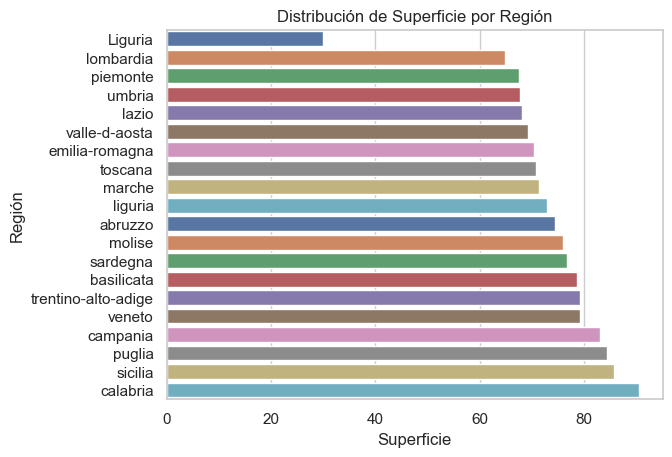

In [44]:
#Determinamos las especificaciones del grafico
sns.barplot(data=superf_prom_region, y='region', x='superficie', orient='h', palette="deep")

# Configurar las etiquetas y el título
plt.xlabel('Superficie')
plt.ylabel('Región')
plt.title('Distribución de Superficie por Región')

# Mostrar el gráfico de barras horizontal
plt.show()

Lo más conveniente si lo que se busca ofrecer es una vivienda económica pero con buen espacio, la región "Liguria" es una excelente opción para estudiar la compra de una vivienda.
Ahora, la Región "Calabria" se encuentra como una de las regiones con mayor superficie en sus inmuebles, y con un precio normal, ni dentro de los más altos, ni dentro de los más bajos.


**10. Entrenando Algoritmos de Machine Learning**

Utilizaremos la variable "Superficie" para el modelo.

In [45]:
df_alg = df[['precio', 'superficie', 'banos', 'habitaciones']]
df_alg.head()

,precio,superficie,banos,habitaciones
12,1800,63,1.0,2.0
13,500,35,1.0,1.0
15,825,44,1.0,2.0
16,550,60,1.0,3.0
17,1300,143,2.0,0.0


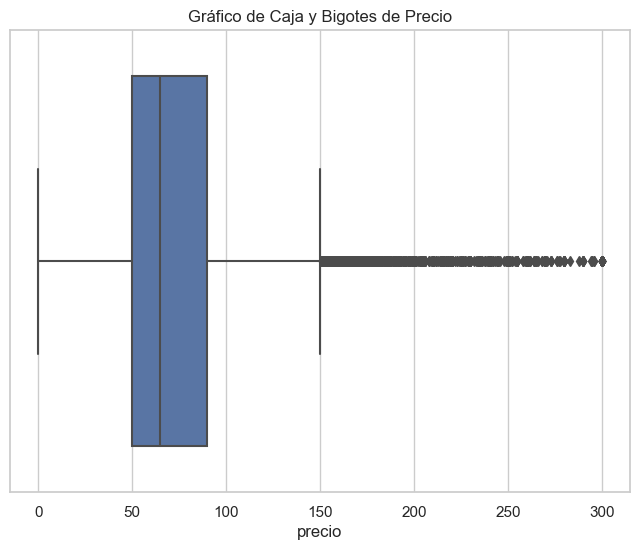

In [46]:
#Configuración del grafico
sns.set(style="whitegrid")

#Grafico de Caja y Bigotes para visualizar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_alg["superficie"])
plt.title("Gráfico de Caja y Bigotes de Precio")
plt.xlabel("precio")
plt.show()

Eliminamos outliers para un mejor desempeño del modelo y visualizamos nuevamente.

In [47]:
df_alg.drop(df_alg[(df_alg['superficie'] > 150)].index, inplace=True)
df_alg.drop(df_alg[(df_alg['superficie'] < 20)].index, inplace=True)

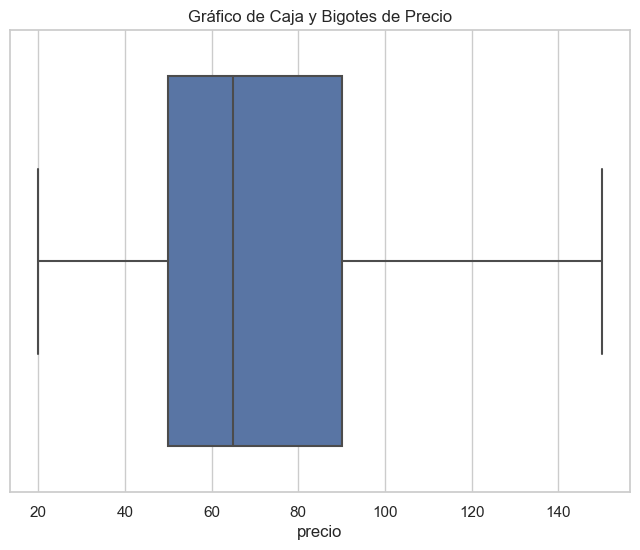

In [48]:
#Configuración del grafico
sns.set(style="whitegrid")

#Grafico de Caja y Bigotes para visualizar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_alg["superficie"])
plt.title("Gráfico de Caja y Bigotes de Precio")
plt.xlabel("precio")
plt.show()

In [49]:
# Divide el conjunto de datos en características y variable objetivo
X = df_alg[['precio', 'banos', 'habitaciones']]
y = df_alg['superficie']

In [50]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Crea el modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evalúa el modelo
rmse = mean_squared_error(y_test, y_pred, squared=False).round(1)
mae = mean_absolute_error(y_test, y_pred).round(1)
mse = mean_squared_error(y_test, y_pred, squared=True).round(1)
r2 = r2_score(y_test, y_pred).round(2)

print("Error cuadrático medio:", mse)
print("R. Error cuadrático medio:", rmse)
print("Mean Absolute Error:", mae)
print("Coeficiente de determinación:", r2)


Error cuadrático medio: 372.1
R. Error cuadrático medio: 19.3
Mean Absolute Error: 13.9
Coeficiente de determinación: 0.54


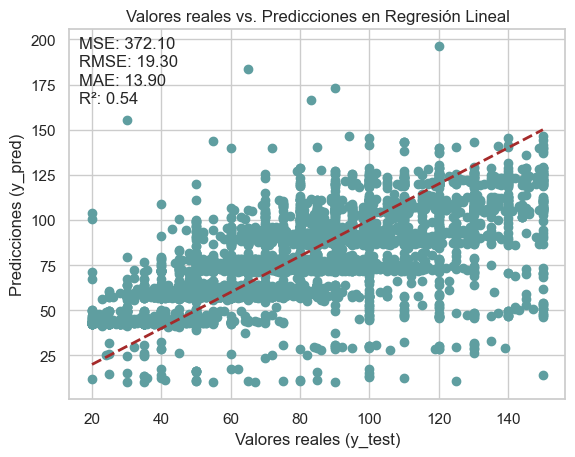

In [52]:
# Graficar los valores reales vs. predicciones
plt.scatter(y_test, y_pred, color='cadetblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='brown', linewidth=2)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.annotate(f'MSE: {mse:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', ha='left')
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.02, 0.90), xycoords='axes fraction', ha='left')
plt.annotate(f'MAE: {mae:.2f}', xy=(0.02, 0.85), xycoords='axes fraction', ha='left')
plt.annotate(f'R²: {r2:.2f}', xy=(0.02, 0.80), xycoords='axes fraction', ha='left')
plt.title("Valores reales vs. Predicciones en Regresión Lineal")
plt.show()

Visualmente esta bastante concentrado entre los 20Mts2 y 150Mts2, si bien no sigue de manera perfecta la línea, la distribución se comporta de manera logica.

**Teniendo como referencia la variable "Superficie", analizamos los resultados:**
- **El MSE** de 372.1 indica que las predicciones del modelo tienen un nivel aceptable de error cuadratico medio en relación con el rango de datos.

- **El RMSE** de 19.3 nos indica que las predicciones tienen una dispersión promedio de mas o menos 19.3, lo cual es un valor bastante aceptable segun nuestros datos.

- **El MAE** de 13.9 indica que en promedio las predicciones difieren en 13.9 de las superficies reales. Este valor es bastante bajo, considerando el rango de datos, por lo que es un buen indicativo.

- **El coeficiente de determinación** de 0.54 nos indica que el modelo explica un 54% de la variabilidad en las superficies de los inmuebles. Aunque no es tan alto, es un buen porcentaje de explicación, sin embargo se pueden mejorar estas metricas.

**11. CrossValidation y Mejora del modelo**:

In [57]:
model = RandomForestRegressor(random_state=42, n_estimators=10,max_depth=4)
scores = cross_val_score(model, X, y, cv=15, verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.6s finished


In [58]:
print("%0.2f de r2 promedio con una desviacion estandar de %0.2f" % (scores.mean(), scores.std()))

0.67 de r2 promedio con una desviacion estandar de 0.02


- El **r2** ó coeficiente de determinación de 0.67 nos indica que el modelo explica un 67% de la variabilidad en las superficies de los inmuebles. Mejoro 13 puntos sobre el modelo original, lo cual significa que anteriormente nuestro modelo estaba un poco bajo underfiting y este modelo de Crossvalidation lo mejoro, usando 15 particiones.

**Conclusión**:

- Aunque el conjunto de datos no era suficiente para un estudio efectivo, se realizaron sin embargo los análisis demandados con la data disponible y dándole el sentido necesario para la investigación. Las variables con más fuerza eran las variables de Precio, Superficie, y cantidad de baños de una propiedad, por lo que el estudio al finalmente se enfocó en estas tres. En definitivo los resultados demostraron que efectivamente y como se esperaba la superficie del inmueble influye en el precio, y que este tiende a crecer con el tiempo, también influye mucho la región, se pueden conseguir inmuebles con buena superficie a un buen precio, pero en ciertas regiones. Información que es relevante para la presentación de opciones a los clientes.